# Plot mcc tree with host transitions and summarize tree 

I've run a 3-deme, multitype tree model in beast. I turned off migration rates from humans (so there can be no human to bird migration events) and ran 3 chains for 100,000 steps each. Honestly, the runs did not converge very well. The model REALLY wants humans to be a source population, I think because of rapid coalescence in the poultry deme. So I think from looking at the summary tree that there are quite a few inferred wild to human events, which is weird. I think from a cursory glance that we are also underestimating the circulation within the poultry deme. However, I need to actually plot out the tree and the estimates to be sure and to think about next steps for how to maybe get a more realistic picture of host switching. 

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [5]:
# tree_paths
constant_human_on = ""
constant_human_off = {"label": "constant-human-off",
    "tree":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/2021-03-15-mascot-3deme-constant-human-off.combined.mcc.tree"}
skyline_human_on =  ""
skyline_human_off = {"label": "skyline-human-off", 
                     "tree": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-trees-2021-08-23.mcc.tree"}

In [6]:
# read in tree
to_run = skyline_human_off

tree = bt.loadNexus(to_run['tree'])
label = to_run['label']

In [7]:
for k in tree.Objects: 
    if k.branchType == "leaf":
        #print(k.name)
        pass

## Get clades information

In [8]:
def return_clades_dict(clades_file, cladese_mapping):
    h5n1_clades_dict = {}

    with open(clades_file, "r") as infile: 
        for line in infile: 
            if "clade" not in line: 
                strain = line.split("\t")[0]
                clade = line.split("\t")[1].strip()

                if clade not in clade_mapping: 
                    print(clade)
                else:
                    clade_group = clade_mapping[clade]
                h5n1_clades_dict[strain] = {"clade":clade, "clade_group":clade_group}
        
    return(h5n1_clades_dict)

In [9]:
# condense clades into groups
clade_mapping = {
"0":"0",
 
"1":"1",
"1.1":"1",
"1.1-like":"1",
"1.1.1":"1",
"1.1.2":"1",
 
"2.1":"2.1",
"2-like":"2.1",
"2.1.1":"2.1",
"2.1.2":"2.1",
"2.1.3":"2.1",
"2.1.3.1":"2.1",
"2.1.3.2":"2.1",
"2.1.3.2a":"2.1",
"2.1.3.2b":"2.1",
"2.1.3.3":"2.1",
 
"2.2":"2.2",
"2.2.1":"2.2",
"2.2.1.1":"2.2",
"2.2.1.1a":"2.2",
"2.2.1.2":"2.2",
"2.2.2":"2.2",
"2.2.2.1":"2.2",
 
"2.3":"2.3",
"2.3.1":"2.3",
"2.3.2":"2.3",
"2.3.2.1":"2.3",
"2.3.2.1a":"2.3",
"2.3.2.1b":"2.3",
"2.3.2.1c":"2.3",
"2.3.3":"2.3",
                 
"2.3.4":"2.3.4",
"2.3.4-like":"2.3.4",
"2.3.4.1":"2.3.4",
"2.3.4.2":"2.3.4",
"2.3.4.3":"2.3.4",
"2.3.4.4":"2.3.4",
 
"2.4":"other",
"2.5":"other",
"3":"other",
"3-like":"other",
"4":"other",
"5":"other",
"5-6-like":"other",
"6":"other",
"7":"other",
"7.1":"other",
"7.2":"other",
"8":"other",
"8-9-like":"other",
"9":"other",
"EA-nonGsGD":"non-GsGd",
"Am-nonGsGD":"non-GsGd",
"1-8-9-like":"other", 
"?":"unknown"}

In [10]:
h5n1_clades_file = "/Users/lmoncla/src/avian-flu/clade-labeling/h5n1-clades.tsv"
h5n1_clades_dict = return_clades_dict(h5n1_clades_file, clade_mapping)

In [11]:
tips_in_tree_by_clade = {}

for k in tree.Objects: 
    if k.branchType == "leaf":
        strain = k.name.split("|")[0]
        host = k.name.split("|")[9]
        clade_group = h5n1_clades_dict[strain]['clade_group']
        
        if clade_group not in tips_in_tree_by_clade: 
            tips_in_tree_by_clade[clade_group] = {"human":0, "domestic":0, "wild":0, "total":1}
            tips_in_tree_by_clade[clade_group][host] += 1
        else: 
            tips_in_tree_by_clade[clade_group]["total"] += 1
            tips_in_tree_by_clade[clade_group][host] += 1

print(tips_in_tree_by_clade)

{'2.3': {'human': 7, 'domestic': 132, 'wild': 44, 'total': 183}, '2.3.4': {'human': 29, 'domestic': 31, 'wild': 7, 'total': 67}, '2.2': {'human': 24, 'domestic': 112, 'wild': 28, 'total': 164}, 'other': {'human': 2, 'domestic': 13, 'wild': 2, 'total': 17}, '2.1': {'human': 28, 'domestic': 12, 'wild': 0, 'total': 40}, '1': {'human': 33, 'domestic': 29, 'wild': 10, 'total': 72}, '0': {'human': 2, 'domestic': 4, 'wild': 0, 'total': 6}}


### Plot a full summary tree, colored by host 

In [12]:
def plot_full_mcc_tree(width, length, tree, filename, traitName):
    
    fig,ax = plt.subplots(figsize=(width,length),facecolor='w')

    # node_colors = clr.LinearSegmentedColormap.from_list('custom ', [Not_Marshallese_color,Marshallese_color], N=256)
    color_dict = {"human":human_color, "domestic":domestic_color, "wild":wild_color, "ancestor":'grey'}

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    min_date = 1990
    dates_ls = []
    for i in np.arange(min_date,2021,5):
        dates_ls.append(i) 

    branchWidth=1.25 ## default branch width
    tipSize = 12

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if k.branchType=='leaf': ## if leaf...        
            c=color_dict[k.traits[traitName]]
            s=tipSize
            parent_color = color_dict[k.parent.traits[traitName]]
            a=k.parent.traits[traitName+'.prob']

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9)

        elif k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.0025

            # if we are not at the root
            if k.parent.traits != {}:
                c=color_dict[k.parent.traits[traitName]]
                a=k.parent.traits[traitName+'.prob']
                parent_color = color_dict[k.parent.traits[traitName]]
            else:
                print("root")
                c=color_dict[k.traits[traitName]]
                a=k.traits[traitName+'.prob']
                parent_color = c

            # this is the vertical line connecting nodes; 
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9)
            
            # this is the horizontal line connecting nodes 
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9)

        # add in a legend
        han_list = []

        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    for key in color_dict:
        if key != "ancestor":
            marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("domestic","domestic bird").replace("wild","wild bird"), markersize = 8)
            han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    #ax.set_xlim(1970,2020)
    ax.set_xlim(min_date,2020)
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.03, 0.05], loc=3,prop={'size': 20}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)

    plt.savefig(filename, dpi=600)

    plt.show()

root


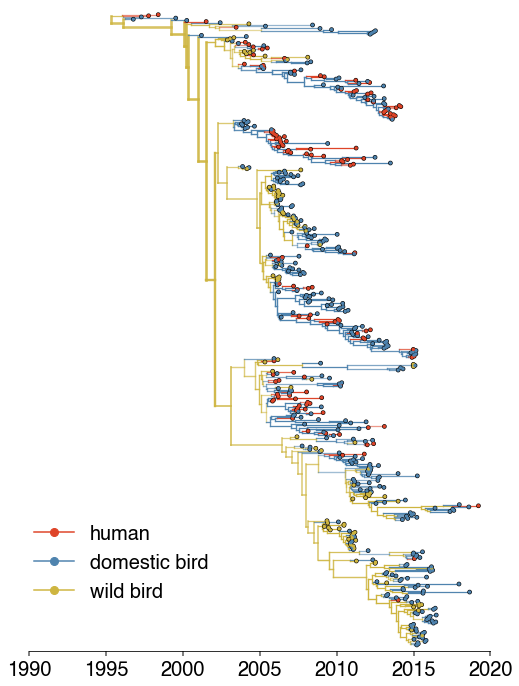

In [165]:
width = 8
length = 10
filename = "figures/mcc-tree-"+label+"-"+current_date #+".pdf"
#filename = "figures/mtt-3deme-1per-region-month-host-noGsGd-2021-01-26.pdf"
traitName = 'max'   # max for mascot, type for mtt

plot_full_mcc_tree(width, length, tree, filename, traitName)

## color mcc tree by region 

In [9]:
def plot_full_mcc_tree_colorby_region(width, length, tree, filename, traitName, color_dict):
    
    fig,ax = plt.subplots(figsize=(width,length),facecolor='w')

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    min_date = 1990
    dates_ls = []
    for i in np.arange(min_date,2021,5):
        dates_ls.append(i) 

    branchWidth=1.25 ## default branch width
    tipSize = 24

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if k.branchType=='leaf': ## if leaf...
            region = k.name.split("|")[4]
            c=color_dict[region]
            s=tipSize
            parent_color = "black"

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,ls='-',zorder=9)

        elif k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth #+ number_children*0.0025

            # if we are not at the root
            if k.parent.traits != {}:
                c="black"
                parent_color = "black"
            else:
                print("root")
                c="black"
                parent_color = c

            # this is the vertical line connecting nodes; 
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9)

            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,ls='-',zorder=9)

        # add in a legend
        han_list = []

        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    for key in color_dict:
        if key != "ancestor":
            marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("domestic","domestic bird").replace("wild","wild bird"), markersize = 8)
            han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    #ax.set_xlim(1970,2020)
    ax.set_xlim(min_date,2020)
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.07, 0.05], loc=3,prop={'size': 16}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)

    plt.savefig(filename, dpi=600)

    plt.show()

In [63]:
region_color_dict = {"Southeast_Asia":"#C5656E","North_America":"#438B62", "South_America":"#438B62", 
                    "China":"#93B2D2","South_Asia":"#F9E7C3", "Africa":"#2664A5", "West_Asia":"#695B82", 
                    "Japan_Korea":"#438B62", "Europe":"#EEA160"} # oraaange  green: "#438B62"

root


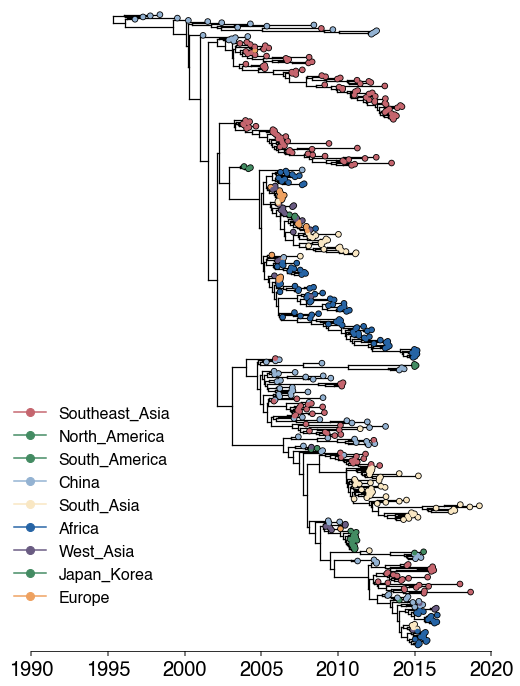

In [50]:
width = 8
length = 10
filename = "figures/mcc-tree-by-region-"+label+"-"+current_date #+".pdf"
traitName = 'max'   # max for mascot, type for mtt

plot_full_mcc_tree_colorby_region(width, length, tree, filename, traitName, region_color_dict)

In [66]:
def plot_full_mcc_tree_colorby_clade(width, length, tree, filename, traitName, color_dict, clades_dict):
    
    fig,ax = plt.subplots(figsize=(width,length),facecolor='w')

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    min_date = 1990
    dates_ls = []
    for i in np.arange(min_date,2021,5):
        dates_ls.append(i) 

    branchWidth=1.25 ## default branch width
    tipSize = 24

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if k.branchType=='leaf': ## if leaf...
            region = k.name.split("|")[4]
            strain = k.name.split("|")[0]
            clade = clades_dict[strain]['clade_group']
            c=color_dict[clade]
            s=tipSize
            parent_color = "black"

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,ls='-',zorder=9)

        elif k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth #+ number_children*0.0025

            # if we are not at the root
            if k.parent.traits != {}:
                c="black"
                parent_color = "black"
            else:
                print("root")
                c="black"
                parent_color = c

            # this is the vertical line connecting nodes; 
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9)

            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,ls='-',zorder=9)

        # add in a legend
        han_list = []

        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    for key in color_dict:
        if key != "ancestor":
            marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key, markersize = 8)
            han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    #ax.set_xlim(1970,2020)
    ax.set_xlim(min_date,2020)
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.07, 0.05], loc=3,prop={'size': 16}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)

    plt.savefig(filename, dpi=600)

    plt.show()

In [76]:
clades_color_dict = {"0":"#EEA160", "1":"#2664A5", "2.1":"#695B82","2.2":"#F9E7C3", "2.3":"#93B2D2",
                     "2.3.4":"#C5656E", "other":"#438B62"} # oraaange  green: "#438B62"

root


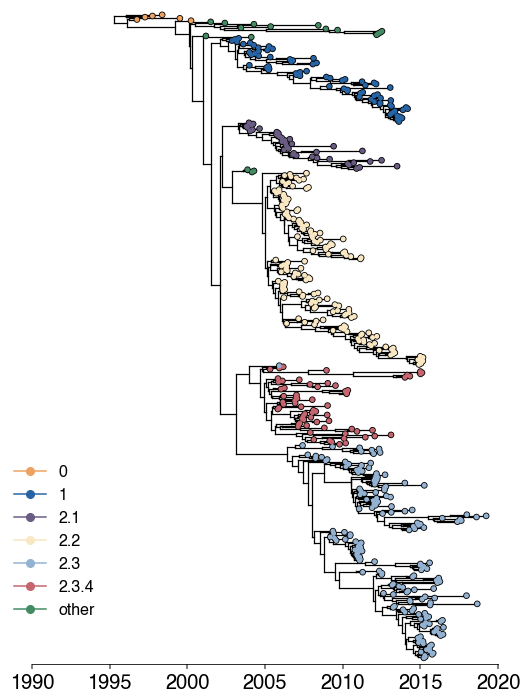

In [77]:
width = 8
length = 10
filename = "figures/mcc-tree-by-clade-"+label+"-"+current_date #+".pdf"
traitName = 'max'   # max for mascot, type for mtt

plot_full_mcc_tree_colorby_clade(width, length, tree, filename, traitName, clades_color_dict, h5n1_clades_dict)

## Enumerate subtrees and plot

In [13]:
"""enumerate host transitions on the tree"""

def retrieve_subtrees(tree, trait):
    
    traitName=trait

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={host:[] for host in hosts_list}
    subtype_trees={host:[] for host in hosts_list}

    for k in sorted(tree.Objects,key=lambda x:x.height):
    
        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName].lower().replace(" ","_")   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=k.parent.traits[traitName].lower().replace(" ","_")     # kploc = trait of parental node
        else:
            kploc='ancestor'

        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName].lower().replace(" ","_")==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                if kloc in subtype_trees:
                    subtype_trees[kloc].append((kploc,subtree))
                else:
                    pass
                    #print(kloc, " not in countries list")
                    
    return(subtype_trees)

In [14]:
"""enumerate host transitions on the tree"""

def retrieve_subtrees_2_deme(tree, trait, target_host, stop_state):
    
    traitName=trait

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={target_host:[]}
    subtype_trees={target_host:[]}

    for k in sorted(tree.Objects,key=lambda x:x.height):

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName].lower().replace(" ","_")   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=k.parent.traits[traitName].lower().replace(" ","_")     # kploc = trait of parental node
        else:
            kploc='ancestor'

        ## if states do not match and the child is the target host
        if kloc!=kploc and kloc == target_host:      # if node and parental node do not have the same trait
            traverse_condition=lambda w:w.traits[traitName].lower().replace(" ","_") in stop_state     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                if kloc in subtype_trees:
                    subtype_trees[kloc].append((kploc,subtree))
                else:
                    pass
                    
    return(subtype_trees)

In [15]:
def plot_exploded_tree(subtype_trees, filename, width, height, traitName, deme, labels):
    
    color_dict = {"human":human_color, "domestic":domestic_color, "wild":wild_color, "ancestor":"grey"}#,
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    branchWidth=1.25 ## default branch width
    tipSize = 15
    origin_size=50

    mpl.rcParams['font.size']=16
    cumulative_y=0

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(1990,2030,5): 
        dates.append(i)
    #[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

    for subtree in reversed(subtype_trees[deme]): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            c = color_dict[k.traits[traitName]]
            s = tipSize
            a = k.traits[traitName+".prob"]
 
            if k.branchType == "leaf":
                #region = k.name.split("|")[4]
                #c = color_dict[region]
                ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)
                
                if labels == "yes":
                    label = k.name.split("|")[0]
                    ax1.text(x+0.3,y,label, fontsize=4,zorder=13)
                else:
                    pass
                              
            elif k.branchType == "node": 
                #c = "black"
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
#                 if xp >= cutoff:
                #c = "black"
                ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                 else:
#                     ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
#                     ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = color_dict[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in color_dict:
        marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[0, 0.12], loc=3, prop={'size': 16}, facecolor='w')

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates)
    #ax1.set_xticklabels(dates, fontsize=14)
    #ax1.axes.get_xaxis().set_ticks([])

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [16]:
def plot_exploded_tree_colorby_region(subtype_trees, filename, color_dict, width, height, traitName, deme, labels):
    
    origin_color_dict = {"human":human_color, "domestic":domestic_color, "wild":wild_color, "ancestor":"grey"}
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    branchWidth=1.25 ## default branch width
    tipSize = 12
    origin_size=50

    mpl.rcParams['font.size']=16
    cumulative_y=0

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(1990,2030,5): 
        dates.append(i)
    #[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

    for subtree in reversed(subtype_trees[deme]): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            s = tipSize
            a = k.traits[traitName+".prob"]
 
            if k.branchType == "leaf":
                region = k.name.split("|")[4]
                c = color_dict[region]
                ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor=c,zorder=100) ## plot tip circle
                ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)
                
                if labels == "yes":
                    label = k.name.split("|")[0]
                    ax1.text(x+0.3,y,label, fontsize=4,zorder=13)
                else:
                    pass
                              
            elif k.branchType == "node": 
                c = "black"
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
#                 if xp >= cutoff:
                c = "black"
                ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                 else:
#                     ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
#                     ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = origin_color_dict[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
             
        # plot dotted line connecting circle to tree 
#         if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
#             ax1.plot([min_node_x,oriX],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

#         elif oriX < cutoff: # partly before 2016, partial dotteds
#             ax1.plot([min_node_x,cutoff],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
#             ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

#         else:
        ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in color_dict:
        marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[0, 0.12], loc=3, prop={'size': 16}, facecolor='w')

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates)
    #ax1.set_xticklabels(dates, fontsize=14)
    #ax1.axes.get_xaxis().set_ticks([])

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [17]:
def plot_exploded_tree_colorby_clade(subtype_trees, filename, color_dict, width, height, traitName, deme, labels, clades_dict):
    
    origin_color_dict = {"human":human_color, "domestic":domestic_color, "wild":"black", "ancestor":"grey"}
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    branchWidth=1.25 ## default branch width
    tipSize = 14
    origin_size=50

    mpl.rcParams['font.size']=16
    cumulative_y=0

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(1990,2030,5): 
        dates.append(i)
    #[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

    for subtree in reversed(subtype_trees[deme]): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            s = tipSize
            a = k.traits[traitName+".prob"]
 
            if k.branchType == "leaf":
                region = k.name.split("|")[4]
                strain = k.name.split("|")[0]
                clade = clades_dict[strain]['clade_group']
                c=color_dict[clade]

                ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor=c,zorder=100) ## plot tip circle
                ax1.scatter(x,y,s=tipSize+5,facecolor="black", alpha=a,edgecolor="black",zorder=99)
                
                if labels == "yes":
                    label = k.name.split("|")[0]
                    ax1.text(x+0.3,y,label, fontsize=4,zorder=13)
                else:
                    pass
                              
            elif k.branchType == "node": 
                c = "black"
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
#                 if xp >= cutoff:
                c = "black"
                ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = origin_color_dict[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        #ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='black',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
             
        ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in color_dict:
        marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[0, 0.12], loc=3, prop={'size': 16}, facecolor='w')

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates)
    #ax1.set_xticklabels(dates, fontsize=14)
    #ax1.axes.get_xaxis().set_ticks([])

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [18]:
hosts_list = ['human','wild','domestic']
trait = 'max'

subtype_trees = retrieve_subtrees(tree, trait)

In [19]:
print(len(subtype_trees['domestic']))
print(len(subtype_trees['human']))

132
112


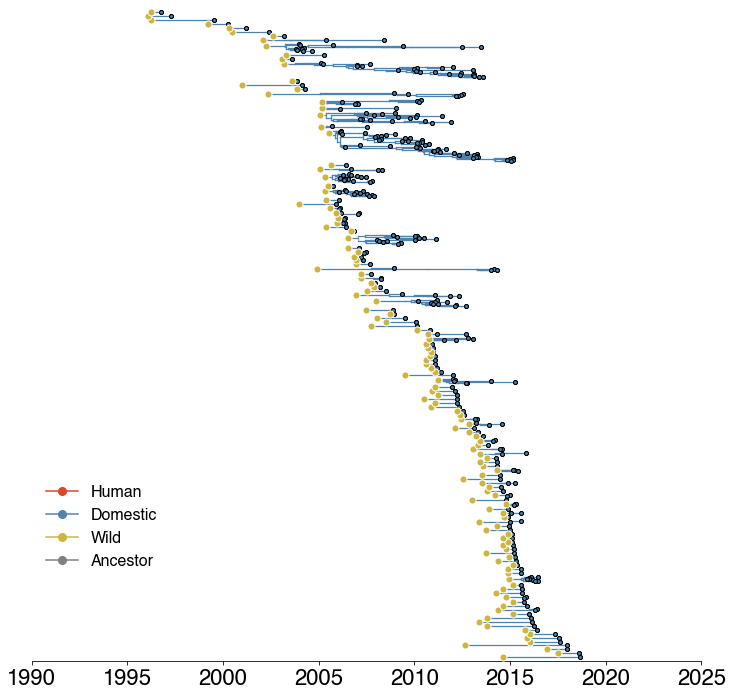

In [45]:
width = 12
height = 12
traitName = 'max'
deme = 'domestic'
labels = "no"
filename = "figures/exploded-tree-region-"+label+"-"+deme+"-"+current_date+".pdf"
#filename = "figures/exploded-tree-mtt-3deme-1per-region-month-host-noGsGd-2021-01-26.pdf"

plot_exploded_tree(subtype_trees, filename, width, height, traitName, deme, labels)

In [20]:
region_color_dict = {"Southeast_Asia":"#C5656E","North_America":"#438B62", "South_America":"#438B62", 
                    "China":"#93B2D2","South_Asia":"#F9E7C3", "Africa":"#2664A5", "West_Asia":"#695B82", 
                    "Japan_Korea":"#438B62", "Europe":"#EEA160"} # oraaange  green: "#438B62"

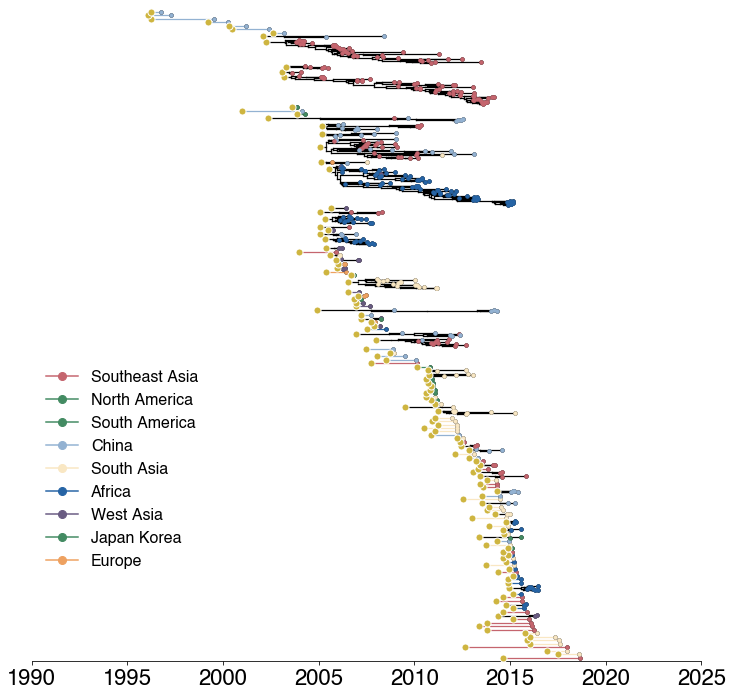

In [23]:
width = 12
height = 12
traitName = 'max'
deme = 'domestic'
labels = "no"
filename = "figures/exploded-tree-region-"+label+"-"+deme+"-"+current_date+".pdf"
#filename = "figures/exploded-tree-mtt-3deme-1per-region-month-host-noGsGd-2021-01-26.pdf"

plot_exploded_tree_colorby_region(subtype_trees2, filename, region_color_dict, width, height, traitName, deme, labels)

In [ ]:
clades_color_dict = {"0":"#EEA160", "1":"#2664A5", "2.1":"#695B82","2.2":"#F9E7C3", "2.3":"#93B2D2",
                     "2.3.4":"#C5656E", "other":"#438B62"} # oraaange  green: "#438B62"

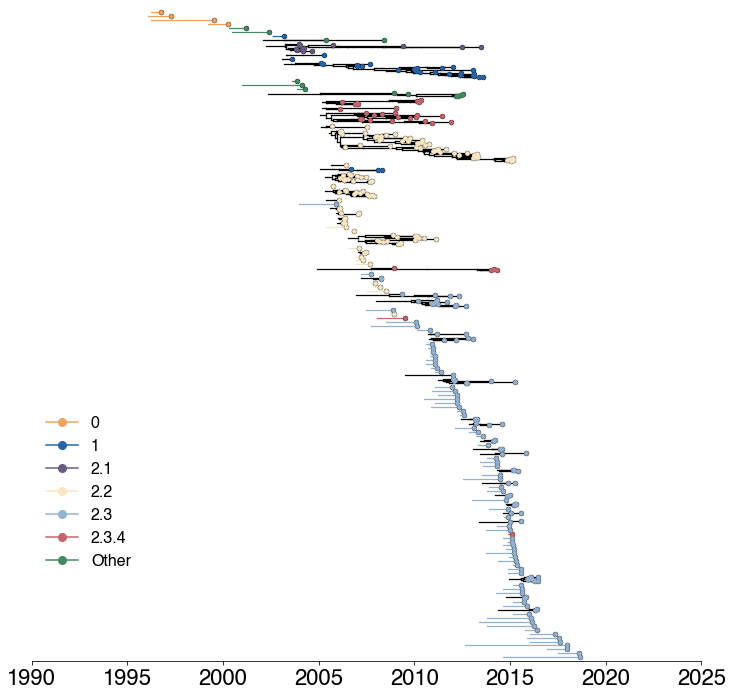

In [99]:
width = 12
height = 12
traitName = 'max'
deme = 'domestic'
labels = "no"
filename = "figures/exploded-tree-clade-"+label+"-"+deme+"-"+current_date+".pdf"

plot_exploded_tree_colorby_clade(subtype_trees, filename, clades_color_dict, width, height, traitName, deme, labels, h5n1_clades_dict)

In [172]:
def plot_exploded_tree(subtype_trees, filename, width, height, traitName, deme, labels):
    
    color_dict = {"human":human_color, "domestic":domestic_color, "wild":wild_color, "ancestor":"grey"}#,
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    branchWidth=1.25 ## default branch width
    tipSize = 15
    origin_size=50

    mpl.rcParams['font.size']=16
    cumulative_y=0

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(1995,2025,5): 
        dates.append(i)
    #[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

    for subtree in reversed(subtype_trees[deme]): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            c = color_dict[k.traits[traitName]]
            s = tipSize
            a = k.traits[traitName+".prob"]
            
            if k.branchType=='leaf': ## if leaf...        
                c=color_dict[k.traits[traitName]]
                s=tipSize
                parent_color = color_dict[k.parent.traits[traitName]]
                a=k.parent.traits[traitName+'.prob']

                ax1.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                ax1.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                
                # this is the horizontal line connecting the tip to its parent node. We want this colored 
                # the color of the parent 
                ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)

            elif k.branchType=='node': ## if node...
                number_children = len(k.leaves)
                node_branchwidth = branchWidth + number_children*0.0025

                # if we are not at the root
                if k.parent.traits != {}:
                    c=color_dict[k.parent.traits[traitName]]
                    a=k.parent.traits[traitName+'.prob']
                    parent_color = color_dict[k.parent.traits[traitName]]
                else:
                    print("root")
                    c=color_dict[k.traits[traitName]]
                    a=k.traits[traitName+'.prob']
                    parent_color = c

                # this is the vertical line connecting nodes
                # we want this to be the color of the current node, since we have actual information for it as 
                # a trait
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
                ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines

#             # this is the vertical line connecting nodes; 
#             ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9)
            
#             # this is the line 
#             ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)
      
        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = color_dict[origin]
        color_line_to_origin = color_dict[deme]
        
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=color_line_to_origin,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in color_dict:
        marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[0, 0.12], loc=3, prop={'size': 16}, facecolor='w')

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates)
    #ax1.set_xticklabels(dates, fontsize=14)
    #ax1.axes.get_xaxis().set_ticks([])

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [22]:
# this will generate an exploded tree with domestic introductions that also includes human tips 
trait = 'max'
target_host = "domestic"
stop_state = ["domestic","human"]

subtype_trees2 = retrieve_subtrees_2_deme(tree, trait, target_host, stop_state)

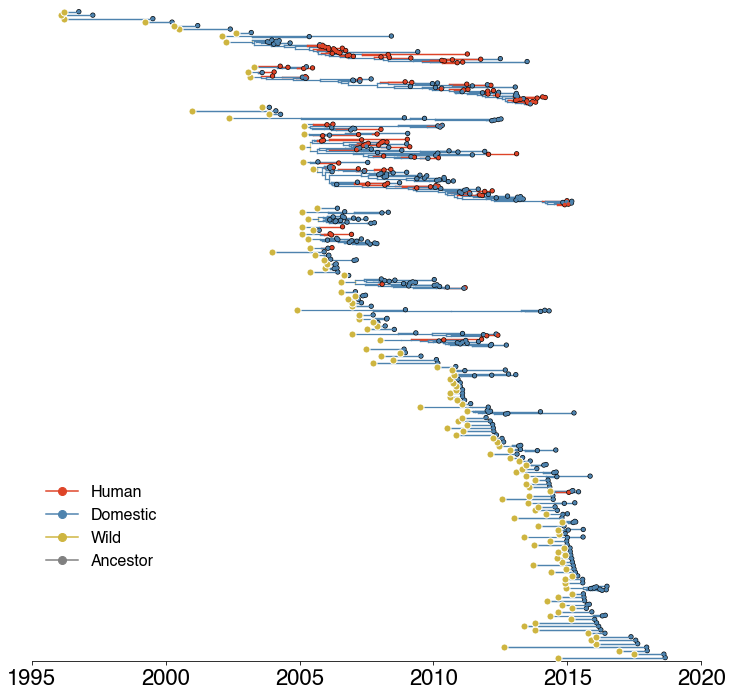

In [173]:
# there is something off about this code. I think it's the plotting, but it could also be the subtrees themselves
width = 12
height = 12
traitName = 'max'
deme = 'domestic'
labels = "no"
filename = "figures/exploded-tree-"+label+"-"+deme+"-"+current_date+".pdf"
#filename = "figures/exploded-tree-mtt-3deme-1per-region-month-host-noGsGd-2021-01-26.pdf"

plot_exploded_tree(subtype_trees2, filename, width, height, traitName, deme, labels)